This notebook tries to extend the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

In particular, we try to generate random images from two classes,
where each class has a different image norm.
The question is: how robust are standard CNN models trained on this dataset?

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

### Data utils

[1 1 1 0 0 0 0 1 1 0]


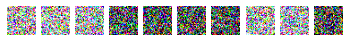

In [4]:
def generate_image_data(image_shape, m1, s1, m2, s2, num_samples):
    assert num_samples % 2 == 0
    
    xs = np.concatenate([
        np.random.normal(loc=m1, scale=s1, size=(num_samples // 2,) + image_shape),
        np.random.normal(loc=m2, scale=s2, size=(num_samples // 2,) + image_shape)
    ]).clip(0, 1)
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def plot_images(xs, flat=True, channels=1):
    for i, x in enumerate(xs):
        plt.subplot(1, len(xs), i + 1)
        plt.imshow(x)
        plt.axis("off")

x_tmp, y_tmp = generate_image_data(
    image_shape=(32, 32, 3),
    m1=0.1, s1=1,
    m2=0.9, s2=1,
    num_samples=10
)

print(y_tmp)
plot_images(x_tmp)

### Experiment setup

In [ ]:
def run_experiment(
    image_shape,
    m1, s1,
    m2, s2,
    model_layers,
    train_batch_size,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    attack_batch_size=1024,
    num_train=5 * 10 ** 4,
    num_test=10 ** 4,
    seed=42
):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_image_data(
        image_shape=image_shape
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        num_samples=num_train,
    )

    x_test, y_test = generate_image_data(
        image_shape=image_shape
        m1=m1, s1=s1,
        m2=m2, s2=s2,
        num_samples=num_test,
    )
    
    model = keras.Sequential(
        [keras.Input(shape=x_train[0].shape)]
        + model_layers
    )
    model.compile(
        loss="SparseCategoricalCrossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        x_train,
        y_train,
        batch_size=train_batch_size,
        epochs=train_epochs,
        validation_split=0.1,
        verbose=1,
    )
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(),
        clip_values=[-x_test.max(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_train_adv = art_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv = art_attack.generate(x_test, y=y_test)
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_train_acc = model.evaluate(x_train_adv, y_train[:num_test], verbose=0)
    _, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)
    
    print("Nat train acc :", nat_train_acc)
    print("Nat test  acc :", nat_test_acc)
    print("Adv train acc :", adv_train_acc)
    print("Adv test  acc :", adv_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv=x_train_adv,
        x_test_adv=x_test_adv,
    )